In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import pylab
import numpy as np
from qiskit import Aer
from qiskit.circuit.library import RealAmplitudes
from qiskit.aqua import QuantumInstance
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.chemistry.drivers import PySCFDriver, UnitsType, HFMethodType
from qiskit.chemistry import FermionicOperator
from groupedFermionicOperator import groupedFermionicOperator

# Get Qubit Hamiltonian

In [2]:
def get_qubit_op_QEE(dist):
    """
    Return H_2 QEE qubit Hamiltonian, number of particles, 
    number of spin orbitals, and energy shift for a given 
    H-H bond distance DIST.
    """
    driver = PySCFDriver(atom="H .0 .0 .0; H .0 .0 " + str(dist), 
                         unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='6-31G')
    molecule = driver.run()
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, 
                              h2=molecule.two_body_integrals)
    g = groupedFermionicOperator(ferOp, num_particles, mode='rhf')
    qubitOp = g.to_paulis()
    shift =  repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

In [3]:
distance = 0.745
qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op_QEE(distance)
print(qubitOp)

Representation: paulis, qubits: 4, size: 52


In [4]:
exact_result = NumPyEigensolver(qubitOp).run()
exact_energy = np.real(exact_result.eigenvalues)[0] + shift
print("Exact Energy:", exact_energy, "Hartree")

Exact Energy: -1.1516969139040383 Hartree


# Variational Quantum Eigensolver

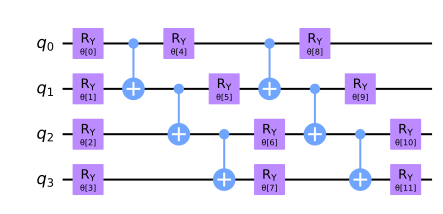

In [5]:
# Define ansatz
ansatz = RealAmplitudes(4, entanglement='linear', reps=2)
ansatz.draw('mpl')

In [6]:
iterations = 5000
backend = Aer.get_backend('statevector_simulator')
qi = QuantumInstance(backend=backend)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

cobyla = COBYLA(maxiter=iterations)
vqe = VQE(var_form=ansatz, optimizer=cobyla, 
          callback=store_intermediate_result, 
          quantum_instance=qi, initial_point=[0.]*12)
result = vqe.compute_minimum_eigenvalue(operator=qubitOp)

In [7]:
vqe_energy = result.eigenvalue.real + shift
print("VQE Energy:", vqe_energy, "Hartree")
print("Error:", abs(627.5 * (vqe_energy - exact_energy)), "kcal/mol")

VQE Energy: -1.1516949358933763 Hartree
Error: 0.0012412016903606826 kcal/mol


Text(0.5, 1.0, 'Energy convergence')

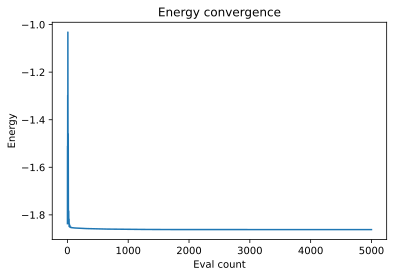

In [8]:
# Visualize convergence
pylab.rcParams['figure.figsize'] = (6, 4)
pylab.plot(counts, values)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence')